In [1]:
version = "REPLACE_PACKAGE_VERSION"

---
# Assignment 3 Part 1: Single Time Series Forecasting (50 pts)

In this assignment, we're going to practise forecasting a single time series. 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Suppress warnings
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.simplefilter("ignore", ValueWarning)

In [3]:
# Disabling warnings only when this assignment is being graded. Nothing is actually tested here.

We will explore the same time series about **daily new COVID-19 cases globally** as we had in **Assignment 2 Part 1**. In order not to reinvent the wheel, let's import the `load_data` function you wrote previously. 

In [4]:
# Copy and paste the function you wrote in Assignment 2 Part 1 here and import any libraries necessary
# We have tried a more elegant solution by using
# from ipynb.fs.defs.assignment2_part1 import load_data
# but it doesn't work with the autograder...

def load_data():
    daily_new_cases = None
    df = pd.read_csv("assets/time_series_covid19_confirmed_global.csv")
    df = df.iloc[:,4:].sum(axis=0).reset_index()
    df['index'] = pd.to_datetime(df['index'])

    df[0] = df[0].diff()

    daily_new_cases = df.iloc[1:,:]
    daily_new_cases = daily_new_cases.groupby(['index'])[0].sum()
    
    return daily_new_cases

In [5]:
# Sanity checks to make sure you have imported the correct function - no points awarded

stu_ans = load_data()

assert isinstance(stu_ans, pd.Series), "Q0: Your function should return a pd.Series. "
assert len(stu_ans) == 212, "Q0: The length of the series returned is incorrect. "
assert isinstance(stu_ans.index, pd.DatetimeIndex), "Q0: The index of your series must be a pd.DatetimeIndex. "
assert (("2020-01-23" <= stu_ans.index) & (stu_ans.index <= "2020-08-21")).all(), "Q0: The index of your series contains an incorrect time range. "
assert not stu_ans.isna().any(), "Q0: Your series contains NaN values. "
assert np.issubdtype(stu_ans.dtype, np.floating), "Q0: Your series should have a float dtype. "

del stu_ans

## Question 1: Stationarity Tests (20 pts)

Let's first try to understand whether our time series is stationary or not. Recall that a stationary time series has stable statistics, such as constant means and variances, over time. A non-stationary time series would not be very interesting to study, as it is essentially equivalent to a white noise, carrying little information. 

### Question 1a (15 pts)

One way of determining stationarity is to calculate some summary statistics. A rolling mean and a rolling standard deviation are the mean and the standard deviation over a rolling window of values. They both have the same length as the original time series. For a rolling window of size $k$, the $j$-th component of the rolling mean $\mu$ and the rolling standard deviation $\sigma$ is precisely defined as:

\begin{align}
\mu_{j} &= \frac{1}{\min(k, j)} \sum_{i = \max(1,j - k + 1)}^{j} x_{i} = \begin{cases}
\frac{1}{j} \sum_{i = 1}^{j} x_{i} & \text{if } j \leq k \\
\frac{1}{k} \sum_{i = j - k + 1}^{j} x_{i} & \text{if } j > k
\end{cases} 
\\
\sigma_{j} &= \sqrt{\frac{1}{\min(k, j)} \sum_{i = \max(1,j - k + 1)}^{j} \left(x_{i} - \mu_{j}\right)^{2}} = \begin{cases}
\sqrt{\frac{1}{j} \sum_{i = 1}^{j} \left(x_{i} - \mu_{j}\right)^{2}} & \text{if } j \leq k \\
\sqrt{\frac{1}{k} \sum_{i = j - k + 1}^{j} \left(x_{i} - \mu_{j}\right)^{2}} & \text{if } j > k
\end{cases}
\end{align}

where $j \geq 1$.

Complete the function below that takes as input a time series and that calculates the rolling mean and the rolling standard deviation of the input time series. The size of the rolling window is governed by the argument `wd_size`. 

**This function should return a `tuple` of length 2, whose first component is the rolling mean as a `np.ndarray` and whose last component is the rolling standard deviation as a `np.ndarray`.**

In [6]:
def calc_rolling_stats(ser, wd_size=7):
    """
    Takes in a series and returns the rolling mean and the rolling std for a window of size wd_size
    """
    
#     rolling_mean, rolling_std = None, None
#     rolling_mean = ser.rolling(window=wd_size,min_periods=1).mean().values
#     rolling_std = ser.rolling(window=wd_size).std().fillna(0).values
    rolling_mean, rolling_std = [], []
    for j in range(1,len(ser)+1):
        means = 0
        if j<= wd_size:
            for i in range(1,j+1):
                means = means + ser[i-1]
            rolling_mean.append(means*(1/j))
        if j > wd_size:
            for i in range(j-wd_size+1, j+1):
                means = means + ser[i-1]
            rolling_mean.append(means*(1/wd_size))
            
    for j in range(1,len(ser)+1):
        stds = 0
        if j <= wd_size:
            for i in range(1, j+1):
                stds = stds + (ser[i-1] - rolling_mean[j-1])**2
            rolling_std.append((stds*(1/j))**.5)
        if j > wd_size:
            for i in range(j-wd_size +1, j+1):
                stds = stds + (ser[i-1] - rolling_mean[j-1])**2
            rolling_std.append((stds *(1/wd_size))**.5)
                    
    return np.array(rolling_mean), np.array(rolling_std)

In [7]:
# ser = load_data()
# wd_size = 5
# rolling_mean = ser.rolling(window=wd_size,min_periods=1).mean().values
# rolling_std = ser.rolling(window=wd_size).std().fillna(0).values
# print(rolling_std.shape)
# rolling_std

In [8]:
# Autograder tests

stu_ser, wd_size = load_data(), 7
stu_ans = calc_rolling_stats(stu_ser, wd_size)

assert isinstance(stu_ans, tuple), "Q1a: Your function should return a tuple. "
assert len(stu_ans) == 2, "Q1a: The length of the tuple returned is incorrect. "
assert isinstance(stu_ans[0], np.ndarray), "Q1a: Please return the rolling mean as np.ndarray. "
assert isinstance(stu_ans[1], np.ndarray), "Q1a: Please return the rolling std as np.ndarray. "
assert len(stu_ans[0]) == len(stu_ser), "Q1a: Your rolling mean should be of the same length as your data. "
assert len(stu_ans[1]) == len(stu_ser), "Q1a: Your rolling std should be of the same length as your data. "
assert np.issubdtype(stu_ans[0].dtype, np.floating), "Q1a: Your rolling mean should have a float dtype. "
assert np.issubdtype(stu_ans[1].dtype, np.floating), "Q1a: Your rolling std should have a float dtype. "


# Some hidden tests


del stu_ans, stu_ser, wd_size

Let's plot and see the rolling statistics together with the original time series. Is our time series stationary? Why or why not? 

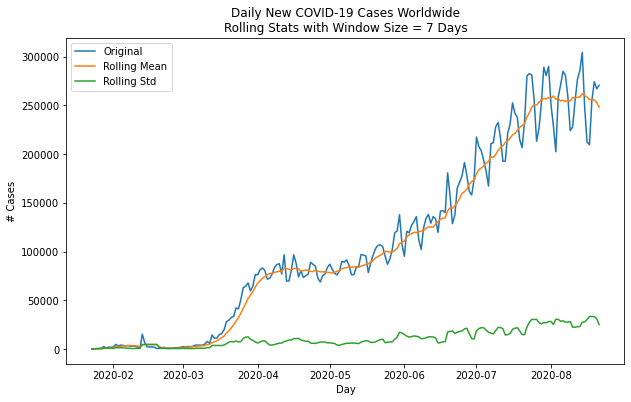

In [9]:
# Let's plot and see the rolling statistics

ser, wd_size = load_data(), 7
rolling_mean, rolling_std = calc_rolling_stats(ser, wd_size)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(ser, label="Original")
ax.plot(pd.Series(rolling_mean, index=ser.index), label="Rolling Mean")
ax.plot(pd.Series(rolling_std, index=ser.index), label="Rolling Std")

ax.set_xlabel("Day")
ax.set_ylabel("# Cases")
ax.set_title("Daily New COVID-19 Cases Worldwide\n" + f"Rolling Stats with Window Size = {wd_size} Days")
ax.legend()

del fig, ax, ser, wd_size, rolling_mean, rolling_std

### Question 1b (5 pts)

Now let's see whether the *log return* of our time series is stationary. Complete the function below that computes the log return of a given time series and that returns the result as a `pd.Series` like the following:

```
2020-01-24    1.064362
2020-01-25    0.541027
2020-01-26    0.327449
2020-01-27    0.167841
2020-01-28    1.186893
                ...   
2020-08-17   -0.013336
2020-08-18    0.196096
2020-08-19    0.072750
2020-08-20   -0.026456
2020-08-21    0.013266
Length: 211, dtype: float64
```

where
* the index of the series is a `pd.DatetimeIndex`; 
* the values of the series are the log returns; and
* the series doesn't contain any `NaN` values. 

**This function should return a `pd.Series`, whose index is a `pd.DatetimeIndex`.**

In [10]:
def calc_log_ret(ser):
    """
    Takes in a series and computes the log return
    """
    
    log_ret = None
    log_ret = np.log(ser) - np.log(ser.shift(1))
    log_ret = log_ret.dropna()
    log_ret = pd.Series(log_ret.values, index=log_ret.index)
    
    return log_ret

In [11]:
# Autograder tests

stu_ser = load_data()
stu_ans = calc_log_ret(stu_ser)

assert isinstance(stu_ans, pd.Series), "Q1b: Your function should return a pd.Series. "
assert len(stu_ans) == len(stu_ser) - 1, "Q1b: The length of the series returned should be one less than that of your data. "
assert isinstance(stu_ans.index, pd.DatetimeIndex), "Q1b: The index of your series must be a pd.DatetimeIndex. "
assert (("2020-01-24" <= stu_ans.index) & (stu_ans.index <= "2020-08-21")).all(), "Q1b: The index of your series contains an incorrect time range. "
assert not stu_ans.isna().any(), "Q1b: Your series contains NaN values. "
assert np.issubdtype(stu_ans.dtype, np.floating), "Q1b: Your series should have a float dtype. "

# Some hidden tests


del stu_ans, stu_ser

This time let's plot and see the rolling statistics together with the log returns. Are the log returns of our time series stationary? Why or why not? 

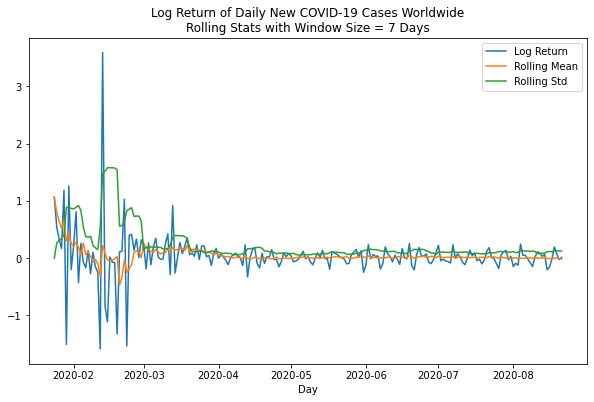

In [12]:
# Let's plot and see the rolling statistics

log_ret, wd_size = calc_log_ret(load_data()), 7
rolling_mean, rolling_std = calc_rolling_stats(log_ret, wd_size)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(log_ret, label="Log Return")
ax.plot(pd.Series(rolling_mean, index=log_ret.index), label="Rolling Mean")
ax.plot(pd.Series(rolling_std, index=log_ret.index), label="Rolling Std")

ax.set_xlabel("Day")
ax.set_title("Log Return of Daily New COVID-19 Cases Worldwide\n" + f"Rolling Stats with Window Size = {wd_size} Days")
ax.legend()

del fig, ax, log_ret, wd_size, rolling_mean, rolling_std

Yet another way of determining stationarity would be to use a statistical test, such as the [Augmented Dickey-Fuller unit root test](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test). The null hypothesis is usually that the time series is non-stationary. A $p$-value less than $0.05$ would lead to the conclusion that the time series is stationary, although [some scientists have risen up against this magic numer](https://www.nature.com/articles/d41586-019-00857-9)!

In [13]:
# An example of performing an Augmented Dickey-Fuller unit root test

from statsmodels.tsa.stattools import adfuller

_, pval, *_ = adfuller(load_data())
print(f"p-value: {pval}")

del adfuller, pval

p-value: 0.6765852511544113


## Question 2: Autocorrelations (10 pts)

Observations in a time series are often not isolated but rather correlated. That is, there might be a correlation between an observation $y_{t}$ and another observation $y_{t - k}$ that is $k$ time steps (or *lags*) earlier. (Partial) autocorrelations precisely capture this idea. 

### Question 2a (5 pts)

Complete the function below to calculate the **Autocorrelation Function (ACF)** of the input time series, with the maximum number of lags to consider specified by the parameter `max_lag`. You may use the `acf` function from the `statsmodels` library. 

**This function should return a `np.ndarray` of length `max_lag + 1`.**

In [14]:
def calc_acf(ser, max_lag):
    """
    Takes a series and calculates the ACF
    """
    
    ans_acf = None
    from statsmodels.tsa.stattools import acf
    ans_acf = acf(ser, nlags=max_lag, fft=False)
    
    return ans_acf

In [15]:
# Autograder tests

stu_ser, max_lag = load_data(), 30
stu_ans = calc_acf(stu_ser, max_lag)

assert isinstance(stu_ans, np.ndarray), "Q2a: Your function should return a np.ndarray. "
assert len(stu_ans) == max_lag + 1, "Q2a: The length of the ACF returned is incorrect. "
assert np.issubdtype(stu_ans.dtype, np.floating), "Q2a: Your np.ndarray should have a float dtype. "


# Some hidden tests


del stu_ans, stu_ser, max_lag

Let's see a plot of the ACF. 

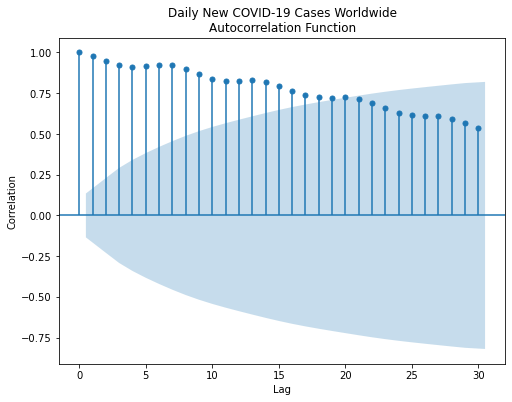

In [16]:
from statsmodels.graphics.tsaplots import plot_acf

ser, max_lag = load_data(), 30

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

plot_acf(ser, ax, lags=max_lag, title="Daily New COVID-19 Cases Worldwide\nAutocorrelation Function")
ax.set_xlabel(r"Lag")
ax.set_ylabel(r"Correlation")

del fig, ax, ser, max_lag, plot_acf

### Question 2b (5 pts)

Complete the function below to calculate the **Partial Autocorrelation Function (PACF)** of the input time series, with the maximum number of lags to consider specified by the parameter `max_lag`. You may use the `pacf` function from the `statsmodels` library. 

**This function should return a `np.ndarray` of length `max_lag + 1`.**

In [17]:
def calc_pacf(ser, max_lag):
    """
    Takes a series and calculates the PACF
    """
    
    ans_pacf = None
    from statsmodels.tsa.stattools import pacf
    
    ans_pacf = pacf(ser, nlags=max_lag)
    
    return ans_pacf

In [18]:
# Autograder tests

stu_ser, max_lag = load_data(), 30
stu_ans = calc_pacf(stu_ser, max_lag)

assert isinstance(stu_ans, np.ndarray), "Q2b: Your function should return a np.ndarray. "
assert len(stu_ans) == max_lag + 1, "Q2b: The length of the PACF returned is incorrect. "
assert np.issubdtype(stu_ans.dtype, np.floating), "Q2b: Your np.ndarray should have a float dtype. "

# Some hidden tests


del stu_ans, stu_ser, max_lag

Let's see a plot of the PACF. 

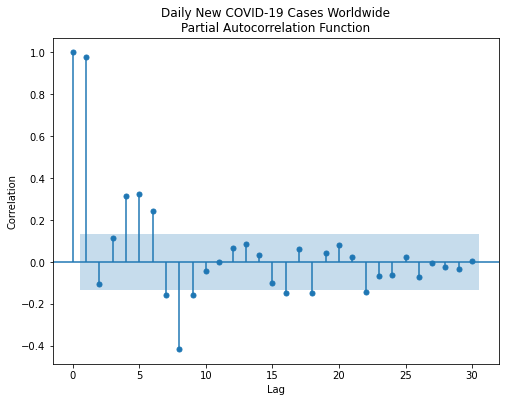

In [19]:
from statsmodels.graphics.tsaplots import plot_pacf

ser, max_lag = load_data(), 30

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

plot_pacf(ser, ax, lags=max_lag, title="Daily New COVID-19 Cases Worldwide\nPartial Autocorrelation Function")
ax.set_xlabel(r"Lag")
ax.set_ylabel(r"Correlation")

del fig, ax, ser, max_lag, plot_pacf

## Question 3: ARMA on Log Returns (10 pts)

Complete the function below that fits an $\mathrm{ARMA}(p, q)$ model on the **log return** of an input series. Your function should return a multi-day forecast in the original data space (i.e., the number of daily new cases globally) starting from `2020-08-22`. For example, if `num_forecasts=20`, your function should return a `pd.Series` similar to


```
2020-08-22    239936.746954
2020-08-23    237307.407386
2020-08-24    240073.408295
                ...
2020-09-08    279778.977067
2020-09-09    307210.157343
2020-09-10    305203.431533
Freq: D, Name: predicted_mean, dtype: float64

```

where
* the index of the series is a `pd.DatetimeIndex`; 
* the values of the series are the forecasted daily new cases; and
* the series doesn't contain any `NaN` values. 

This question is graded on the Root Mean Sqaure Error (RMSE) of your forecasts. You have complete freedom in how you'd like to implement the function, but one recommended API to use is the `ARIMA` class from the `statsmodels` library. Why do we recommend `ARIMA`, when the question actually asks for a $\mathrm{ARMA}(p, q)$ model? Hopefully you'll find it out while working on the implementation!

It's fine if you receive a `ConvergenceWarning` when running your code. In fact, it would be interesting to think about *why* you should receive such. What characteristics of your input time series make the model fail to converge? 

**This function should return a `pd.Series` of length `num_forecasts`, whose index is a `pd.DatetimeIndex`.**

In [20]:
from statsmodels.tsa.arima.model import ARIMA
def arma_log_ret(ser, p, q, num_forecasts):
    """
    Takes a series and fits an ARMA(p, q) model on log return. 
    Returns a number of forecasts as specified by num_forecasts. 
    """
    
    k = np.log(ser)
    forecasts = ARIMA(k, order = (p,1,q)).fit()
    forecasts = forecasts.forecast(num_forecasts)
    forecasts = np.exp(forecasts)
    
    return forecasts

In [21]:
# Autograder tests

stu_ser = load_data()
p, q, num_forecasts = 7, 7, 20

stu_ans = arma_log_ret(stu_ser, p, q, num_forecasts)

assert isinstance(stu_ans, pd.Series), "Q3: Your function should return a pd.Series. "
assert len(stu_ans) == num_forecasts, "Q3: The length of the series returned is incorrect. "
assert isinstance(stu_ans.index, pd.DatetimeIndex), "Q3: The index of your series must be a pd.DatetimeIndex. "
assert (("2020-08-22" <= stu_ans.index) & (stu_ans.index <= "2020-09-10")).all(), "Q3: The index of your series contains an incorrect time range. "
assert not stu_ans.isna().any(), "Q3: Your series contains NaN values. "
assert np.issubdtype(stu_ans.dtype, np.floating), "Q3: Your series should have a float dtype. "

# Some hidden tests


del stu_ser, stu_ans, p, q, num_forecasts

/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Now let's plot and compare the original time series, your forecasts and the ground-truth values of your forecasts. 

/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


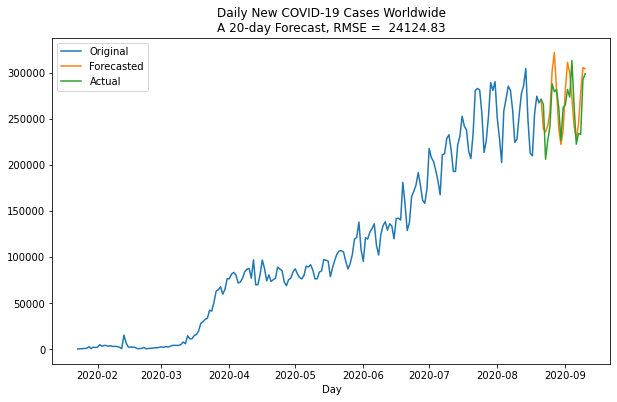

In [22]:
ser = load_data()
p, q, num_forecasts = 7, 7, 20

forecasts = arma_log_ret(ser, p, q, num_forecasts)
actual = pd.read_pickle("assets/actual.pkl")
rmse = np.sqrt(np.mean((actual - forecasts) ** 2))

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(ser, label="Original")
ax.plot(ser[-1:].append(forecasts), label="Forecasted")
ax.plot(ser[-1:].append(actual), label="Actual")

ax.set_xlabel("Day")
ax.set_title("Daily New COVID-19 Cases Worldwide\n" + f"A {len(forecasts)}-day Forecast, RMSE = {rmse: .2f}")
ax.legend()

del fig, ax, ser, p, q, num_forecasts, forecasts, actual

## Question 4: ARMA on First-order Differences (10 pts)

Complete the function below that fits an $\mathrm{ARMA}(p, q)$ model on the **first-order differences** of an input series. Your function should return a multi-day forecast in the original data space (i.e., the number of daily new cases globally) starting from `2020-08-22`. For example, if `num_forecasts=20`, your function should return a `pd.Series` similar to


```
2020-08-22    242994.084820
2020-08-23    205194.792913
2020-08-24    201803.644029
                ...
2020-09-08    214574.419936
2020-09-09    243506.281330
2020-09-10    253847.751339
Freq: D, Name: predicted_mean, dtype: float64
```

where
* the index of the series is a `pd.DatetimeIndex`; 
* the values of the series are the forecasted daily new cases; and
* the series doesn't contain any `NaN` values. 

This question is graded on the Root Mean Sqaure Error (RMSE) of your forecasts. You have complete freedom in how you'd like to implement the function, but one recommended API to use is the `ARIMA` class from the `statsmodels` library. Why do we recommend `ARIMA`, when the question actually asks for a $\mathrm{ARMA}(p, q)$ model? Again, hopefully you'll find it out while working on the implementation!

It's fine if you receive a `ConvergenceWarning` or a `UserWarning` when running your code. Still, it would be interesting to think about what characteristics of your input time series make the model fail to converge. 

**This function should return a `pd.Series` of length `num_forecasts`, whose index is a `pd.DatetimeIndex`.**

In [23]:
from statsmodels.tsa.arima.model import ARIMA

def arma_first_diff(ser, p, q, num_forecasts):
    """
    Takes a series and fits an ARMA(p, q) model on first-order diff. 
    Returns a number of forecasts as specified by num_forecasts. 
    """
    
    forecasts = None
    
    diff_series = ser.diff().dropna()
    model = ARIMA(diff_series, order=(p, 0, q))
    model_fit = model.fit()
    forecasts = model_fit.forecast(steps=num_forecasts)
#     forecasts = pd.Series(data=forecasts, index=pd.date_range(start=ser.index[-1], periods=num_forecasts, freq='D'))
    forecasts = forecasts.cumsum().add(ser[-1])
    
    return forecasts

In [24]:
stu_ser = load_data()
p, q, num_forecasts = 7, 7, 20

stu_ans = arma_first_diff(stu_ser, p, q, num_forecasts)
type(stu_ans)

/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


pandas.core.series.Series

In [25]:
# Autograder tests

stu_ser = load_data()
p, q, num_forecasts = 7, 7, 20

stu_ans = arma_first_diff(stu_ser, p, q, num_forecasts)

assert isinstance(stu_ans, pd.Series), "Q4: Your function should return a pd.Series. "
assert len(stu_ans) == num_forecasts, "Q4: The length of the series returned is incorrect. "
assert isinstance(stu_ans.index, pd.DatetimeIndex), "Q4: The index of your series must be a pd.DatetimeIndex. "
assert (("2020-08-22" <= stu_ans.index) & (stu_ans.index <= "2020-09-10")).all(), "Q4: The index of your series contains an incorrect time range. "
assert not stu_ans.isna().any(), "Q4: Your series contains NaN values. "
assert np.issubdtype(stu_ans.dtype, np.floating), "Q4: Your series should have a float dtype. "

# Some hidden tests


del stu_ser, stu_ans, p, q, num_forecasts

/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Now let's plot and compare the original time series, your forecasts and the ground-truth values of your forecasts. How does this compare with the one trained on log returns? 

/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


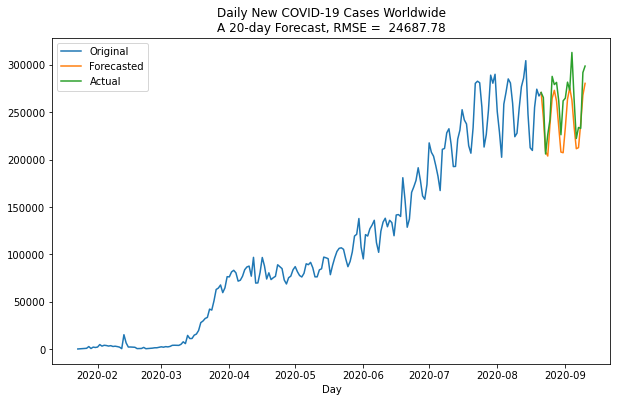

In [26]:
ser = load_data()
p, q, num_forecasts = 7, 7, 20

forecasts = arma_first_diff(ser, p, q, num_forecasts)
actual = pd.read_pickle("assets/actual.pkl")
rmse = np.sqrt(np.mean((actual - forecasts) ** 2))

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(ser, label="Original")
ax.plot(ser[-1:].append(forecasts), label="Forecasted")
ax.plot(ser[-1:].append(actual), label="Actual")

ax.set_xlabel("Day")
ax.set_title("Daily New COVID-19 Cases Worldwide\n" + f"A {len(forecasts)}-day Forecast, RMSE = {rmse: .2f}")
ax.legend()

del fig, ax, ser, p, q, num_forecasts, forecasts, actual